# Comupation of forcing profiles for the MJO skeleton model 
### following method presented in [Ogrosky and Stechman (2015)](https://doi.org/10.1002/qj.2552)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pckl
import netCDF4 as nc
import cftime
import datetime as dt
import xarray
import scipy.interpolate as sp

# CHECKS

In [2]:
# Plot the first two parabolic cylinder functions
R = 6371 # Earth's radius km
lat = np.linspace(-80,80,1000);
y = lat*2*np.pi*R/360.0 / 1500.0; # converts lat into a non-dimentional distance from the equator
phi0 = 1/np.pi**(1/4.0)*np.exp(-y**2/2.0);
phi2 = 1/np.pi**(1/4.0)*np.exp(-y**2/2.0)*(1/2.0/np.sqrt(2))*(4*y**2-2);

(-60.0, 60.0)

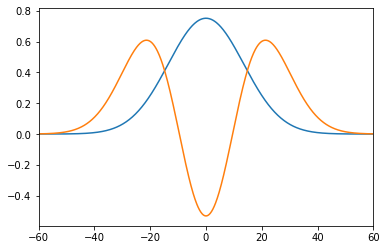

In [3]:
plt.plot(lat, phi0)
plt.plot(lat, phi2)
plt.xlim([-60,60])

# PARAMETERS

In [4]:
Nx = 64

start_year = 1979 
start_month = 1
end_year = 2022 
end_month = 1
months = [1,2,3,4,5,6,7,8,9,10,11,12] 

start_date = dt.datetime(start_year, start_month, 1, 0,0,0)
end_date = dt.datetime(end_year, end_month, 1, 0,0,0)

# FUNCTIONS

In [5]:
def load_data(path, field_name, start_date, end_date, months):
    ds = nc.Dataset(path)
    lon = ds['lon'][:]
    lat = ds['lat'][:]
    times = ds['time']
    dates = nc.num2date(times[:],times.units, only_use_cftime_datetimes=False)

    # select period
    si = np.where(dates==start_date)[0][0]
    ei = np.where(dates==end_date)[0][0]
    field =  ds[field_name][si:ei,:,:]
    dates = dates[si:ei]

    # ! the data should be provied as monthly mean
    dates_pd = pd.to_datetime(dates)
    periods = dates_pd.to_period(freq='M')
        
    # select month 
    mask_months = (periods.month == months[0])
    for m in months[1:]:
        mask_months = (mask_months) | (periods.month == m)
    field = field[mask_months,:,:]
    dates = dates[mask_months]

    return field, lon, lat, dates

In [7]:
def projection(field, lat, lon):
    R = 6371 #[km]
    Nlon = len(lon)
    Nlat = len(lat)
    
    # convert latitudes to distance
    y = lat*2*np.pi*R/360.0 / 1500.0
    dy = abs(y[1]-y[0])
        
    # projection
    phi0 = 1/np.pi**(1/4.0)*np.exp(-y**2/2.0)
    tmp= np.tile(phi0,(Nlon,1))
    phi0_ = tmp.transpose()
    
    mode = np.sum(np.multiply(field,phi0_), axis = 0)*dy
    
    return mode

In [8]:
def compute_Sq(LHF0, HbarA0):
    Hlhf = np.mean(HbarA0)/np.mean(LHF0)*45.0
    return Hlhf * LHF0/45.0

In [9]:
def compute_HbarA0(ltm_precip, lat, lon):
    g = 9.8
    rho_w = 10**3
    p_0 = 1.013*10**5
    L_v = 2.5*10**6
    c_p = 1006.0
    coef = g*rho_w*L_v/(p_0*c_p)
    HbarA = coef * ltm_precip* 10**(-3) / 45.0
    HbarA0 = projection(HbarA, lat, lon)
    return HbarA0

In [10]:
def compute_HbarAmStheta(ltm_olr, lat, lon):
    Holr = 0.056
    ltm_olr_a = np.zeros(ltm_olr.shape)
    for ll, longitude  in enumerate(lon):
        ltm_olr_a[:,ll] = ltm_olr[:,ll] - np.mean(ltm_olr, axis = 1) 
    OLR0a = projection(ltm_olr_a,lat, lon)
    HbarAmStheta = -Holr * OLR0a /45.0
    return HbarAmStheta

In [11]:
def compute_Stheta(HbarA, HbarAmStheta, lon_p, lon_o):
    # interpolation on common grid
    fc1 = sp.CubicSpline(np.append(lon_p.filled(), lon_p[-1]+abs(lon_p[1]-lon_p[0])), np.append(HbarA, HbarA[0]),  bc_type = 'periodic')
    fc2 = sp.CubicSpline(np.append(lon_o.filled(), lon_o[-1]+abs(lon_o[1]-lon_o[0])), np.append(HbarAmStheta, HbarAmStheta[0]), bc_type = 'periodic')
    lon = np.linspace(0, 360, 360, endpoint = False)
    Stheta = fc1(lon) - fc2(lon) 
    return lon, Stheta

In [12]:
# possibility to smooth fields spatially (in longitudes)
def smooth(field, num_k):
    rft = np.fft.rfft(field)
    rft[num_k:] = 0   
    return np.fft.irfft(rft)

In [13]:
# possibility to smooth and scale fields
def smooth_scale(field, num_k, alpha):
    rft = np.fft.rfft(field)
    rft[num_k:] = 0
    rft[1:] = alpha*rft[1:]
    return np.fft.irfft(rft)

In [14]:
def save_profile(lon, Field0, Nt, Nx, file_name):
    profile = np.zeros((Nt, Nx))
    longitudes = np.linspace(0, 360, Nx, endpoint = False)
    for t in range(Nt):
        fc0 = sp.CubicSpline(np.append(lon, lon[-1]+abs(lon[1]-lon[0])), np.append(Field0[t,:], Field0[t,0]),  bc_type = 'periodic')        
        profile[t,:] = fc0(longitudes)
    
    file = open(file_name, 'wb')
    pckl.dump(profile, file)
    file.close()
    
    return longitudes, profile, np.std(profile)

# COMPUTATIONS

# Precipitation

In [37]:
p_file = './../../../../../data/geo/cafe/NCEP/precipitation/precip.mon.mean.nc'
precip, lon_p, lat_p, dates_p = load_data(p_file, 'precip', start_date, end_date, months)
Nt = precip.shape[0] 
HbarA0 = np.zeros((Nt, len(lon_p)))
for t in range(Nt):
    HbarA0[t,:] = smooth(compute_HbarA0(precip[t,:], lat_p, lon_p),9)

file_name = "./data/HbarA0.pckl"
longitudes, HbarA0_ref, std_HbarA0_ref = save_profile(lon_p, HbarA0, Nt, Nx, file_name)


# save longitudes 
file = open("./data/longitudes.pckl", 'wb')
pckl.dump(longitudes, file)
file.close()

# save dates 
file = open("./data/dates.pckl", 'wb')
pckl.dump(dates_p, file)
file.close()

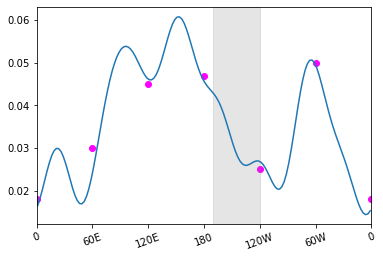

In [16]:
print("Variance : ", std_HbarA0_ref)

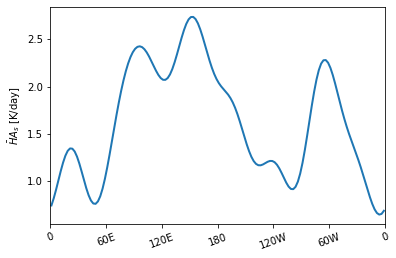

In [19]:
# plot temporal mean
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(lon_p, np.mean(HbarA0,axis = 0)*45,  linewidth = 2, label = r"$\bar{H}A_s$")
plt.xticks([0, 60, 120, 180,240, 300, 360], ['0', '60E', '120E', '180', '120W', '60W', '0'],rotation=20) 
plt.xlim([0,360])
plt.ylabel(r"$\bar{H}A_s$ [K/day]")
plt.rcParams.update({'font.size': 18})
plt.savefig("figures/HbarA_profile.eps", format='eps', dpi = 400,bbox_inches="tight")

# Latent Heat Flux

In [20]:
lhf_file = './../../../../../data/geo/cafe/NCEP/LHF/lhtfl.sfc.mon.mean.nc'
LHF, lon_l, lat_l, dates_l = load_data(lhf_file, 'lhtfl', start_date, end_date, months)
Nt = LHF.shape[0] 
Sq = np.zeros((Nt, len(lon_l)))

for t in range(Nt):
    LHF0 = projection(LHF[t,:], lat_l, lon_l) 
    Sq[t,:] = compute_Sq(LHF0, HbarA0[t,:]) 
    
# smooth
for t in range(Nt):
    Sq[t,:] = smooth(Sq[t,:],9)

###########
file_name = "./data/Sq.pckl"
longitudes, Sq_ref, std_Sq_ref = save_profile(lon_l, Sq, Nt, Nx, file_name)

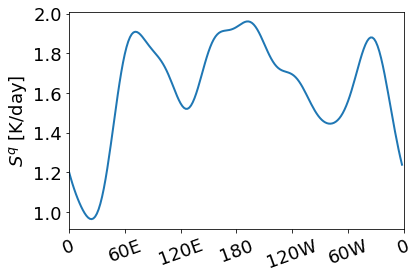

In [24]:
# plot temporal mean
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(lon_l, np.mean(Sq, axis = 0)*45,  linewidth = 2, label = r"$S^q$")
plt.xticks([0, 60, 120, 180,240, 300, 360], ['0', '60E', '120E', '180', '120W', '60W', '0'],rotation=20) 
plt.xlim([0,360])
plt.ylabel(r"$S^q$ [K/day]")
plt.rcParams.update({'font.size': 18})
plt.savefig("figures/Sq_profile.eps", format='eps', dpi = 400,bbox_inches="tight")

# OLR

In [27]:
OLR_file = './../../../../../data/geo/cafe/NCEP/OLR/olr.mon.mean.nc'
OLR, lon_o, lat_o, dates_o = load_data(OLR_file, 'olr', start_date, end_date, months)
Nt = OLR.shape[0] 
HbarAmStheta = np.zeros((Nt, len(lon_o)))

for t in range(Nt):
    HbarAmStheta[t,:] = compute_HbarAmStheta(OLR[t,:], lat_o, lon_o)

for t in range(Nt):
    HbarAmStheta[t,:] = smooth(HbarAmStheta[t,:],9)
    
file_name = "./data/HbarAmStheta.pckl"
longitudes, HbarAmStheta_ref, std_HbarAmStheta_ref = save_profile(lon_o, HbarAmStheta, Nt, Nx, file_name)

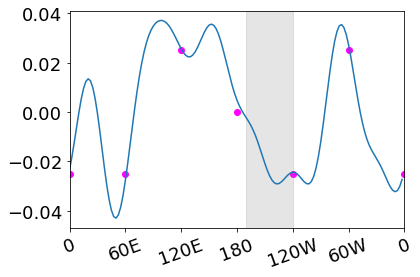

In [28]:
# plot temporal mean
fig, ax = plt.subplots()
plt.plot(lon_o, np.mean(HbarAmStheta, axis = 0))
plt.xticks([0, 60, 120, 180,240, 300, 360], ['0', '60E', '120E', '180', '120W', '60W', '0'],rotation=20) 
plt.xlim([0,360])


# Compute Stheta

In [29]:
Stheta = np.zeros((Nt, 360))
for t in range(Nt):
    lon, Stheta[t,:] = compute_Stheta(HbarA0[t,:], HbarAmStheta[t,:], lon_p, lon_o)

file_name = "./data/Stheta.pckl"
longitudes, Stheta_ref, std_Stheta_ref = save_profile(lon, Stheta, Nt, Nx, file_name)

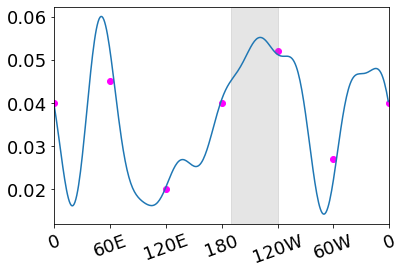

In [30]:
# plot temporal mean

fig, ax = plt.subplots()
plt.plot(lon, np.mean(Stheta, axis=0))

plt.xticks([0, 60, 120, 180,240, 300, 360], ['0', '60E', '120E', '180', '120W', '60W', '0'],rotation=20) 
plt.xlim([0,360])
